[1571.468      1293.467      1015.466       737.465       658.9074
  580.3498      501.7922      423.2346      344.677       321.9329
  299.1888      276.4447      253.7006      230.9565      208.2124
  185.4683      162.7242      139.9801      117.236       110.9792
  104.7224       98.4656       92.2088       85.952        79.6952
   73.4384       67.1816       60.9248       54.668        52.24981
   49.83162      47.41343      44.99524      42.57705      40.15886
   37.74067      35.32248      32.90429      30.4861      143.01289251
  137.43646001  131.86002751  126.28359501  120.70716251  115.13073
  109.5542975   103.977865     98.4014325    92.825        90.385085
   87.94517      85.505255     83.06534      80.625425     78.18551
   75.745595     73.30568      70.865765     68.42585      65.985935
   63.54602      61.106105     58.66619      56.226275     53.78636
   51.346445     48.90653      46.466615     44.0267       43.05342
   42.08014      41.10686      40.13358      39.

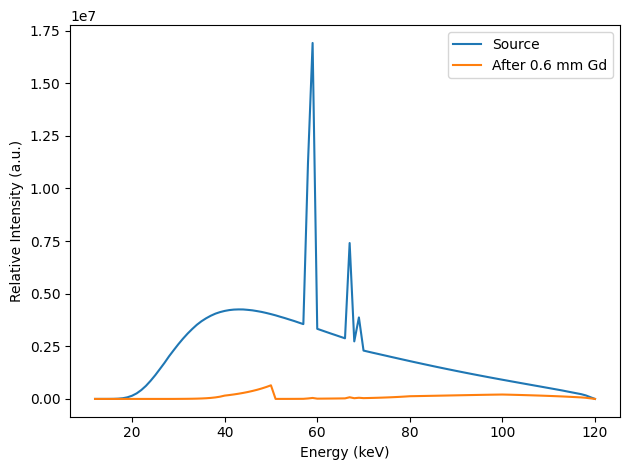

In [30]:
import math, numpy as np

# ---------- 1) 读文件工具（自动跳过非数字行） ----------
def load_two_cols(path):
    E, Y = [], []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            s = ln.strip().split()
            if len(s) < 2: 
                continue
            try:
                e = float(s[0]); y = float(s[1])
            except ValueError:
                continue
            E.append(e); Y.append(y)
    E = np.asarray(E, float); Y = np.asarray(Y, float)
    idx = np.argsort(E)
    return E[idx], Y[idx]

# ---------- 2) 输入路径 ----------
# SpekCalc 导出的原始谱 (两列：Energy[keV], Intensity)
spek_path = "spek_120.txt"
# XCOM Gd 的 (mu/rho) CSV/TXT (两列：Energy[keV], mu_over_rho[cm^2/g])
xcom_gd_path = "Gd_mu_over_rho.csv"

# ---------- 3) 读取数据 ----------
E_keV, Phi_in = load_two_cols(spek_path)
Ex_MeV, mu_over_rho = load_two_cols(xcom_gd_path)  # Gd
 
# ---- 就地把 XCOM 能量统一到 keV（若是 MeV 就 ×1000） ----
# if Ex_MeV.max() < 10 and E_keV.max() > 10:
Ex_keV = Ex_MeV * 1000.0   # MeV -> keV

# ---------- 4) 参数：Gd 密度与厚度 ----------
rho_gd = 7.90       # g/cm^3（Gd 密度）
thickness_mm = 0.6  # 滤波片厚度（mm）
x_cm = thickness_mm * 0.1  # mm -> cm

# ---------- 5) 按教材 N = N0 * exp(-(mu/rho)*rho*x) 计算 ----------
# 先把 (mu/rho)(E) 插值到 Spek 的能量点
mu_rho_interp = np.interp(E_keV, Ex_keV, mu_over_rho, left=mu_over_rho[0], right=mu_over_rho[-1])
mu_cm_inv = mu_rho_interp * rho_gd          # 线性衰减系数 mu(E) [cm^-1]
print(mu_cm_inv)

T = np.exp(-mu_cm_inv * x_cm)               # 透过率
Phi_out = Phi_in * T                        # 衰减后的谱

# ---------- 6) 保存结果 ----------
np.savetxt("spectrum_filtered_Gd.txt", np.column_stack([E_keV, Phi_out]),
           header="Energy_keV  Phi_filtered", fmt="%.6f")

# ---------- (可选) 画图 ----------
try:
    import matplotlib.pyplot as plt
    plt.plot(E_keV, Phi_in,  label="Source")
    plt.plot(E_keV, Phi_out, label="After 0.6 mm Gd")
    plt.xlabel("Energy (keV)"); plt.ylabel("Relative Intensity (a.u.)")
    plt.legend(); plt.tight_layout(); plt.show()
except Exception:
    pass



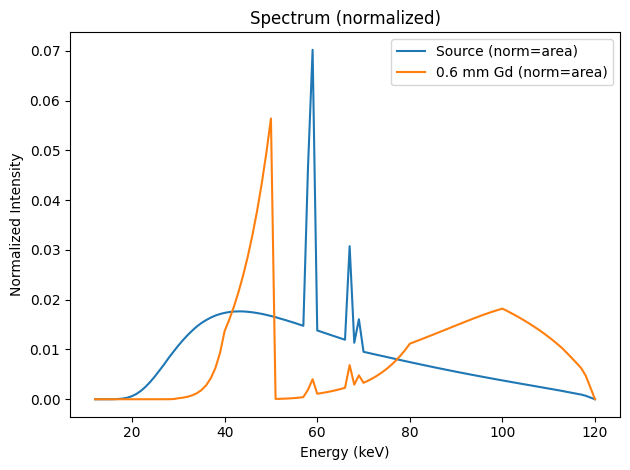

In [31]:
# ---------- (可选) 画图（归一化对比：area 或 peak） ----------
try:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.integrate import trapezoid

    norm_mode = "area"   # 可选: "area" 或 "peak"

    def normalize(E, Y, mode="area"):
        Y = np.asarray(Y, float)
    
        # 兼容 NumPy 1.x / 2.x：优先用 trapezoid，若不存在则回退 trapz
        trap = getattr(np, "trapezoid", np.trapz)
    
        if mode == "area":
            area = trapezoid(np.maximum(Y, 0), E)
            return Y / area if area > 0 else Y
        elif mode == "peak":
            m = np.max(Y) if Y.size else 0.0
            return Y / m if m > 0 else Y
        else:
            return Y

    Phi_in_n  = normalize(E_keV, Phi_in,  norm_mode)
    Phi_out_n = normalize(E_keV, Phi_out, norm_mode)

    plt.plot(E_keV, Phi_in_n,  label=f"Source (norm={norm_mode})")
    plt.plot(E_keV, Phi_out_n, label=f"0.6 mm Gd (norm={norm_mode})")
    plt.xlabel("Energy (keV)")
    plt.ylabel("Normalized Intensity")
    plt.title("Spectrum (normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

[SOURCE] len=109, finite(E)=109, finite(Y)=109, min(Y)=0.0, max(Y)=16909870.0


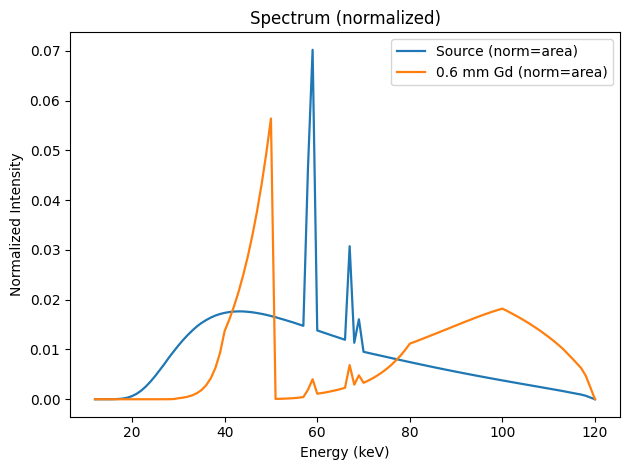

In [32]:
# ---- 计算前先做一次快速体检 ----
def check_array(name, x, y):
    print(f"[{name}] len={len(x)}, finite(E)={np.isfinite(x).sum()}, finite(Y)={np.isfinite(y).sum()}, "
          f"min(Y)={np.nanmin(y) if y.size else 'NA'}, max(Y)={np.nanmax(y) if y.size else 'NA'}")

check_array("SOURCE", E_keV, Phi_in)

# 若有 NaN/Inf，清洗一下
finite_mask = np.isfinite(E_keV) & np.isfinite(Phi_in)
E_keV = E_keV[finite_mask]
Phi_in = Phi_in[finite_mask]

# 万一只有一个点或为空，直接退出以免后面 silently fail
if E_keV.size < 2:
    raise ValueError("源谱点数少于 2，无法绘制。请检查 spek_120.txt 的路径与内容。")

# ---- 归一化函数（处理 NaN/Inf/全零），兼容 numpy 2.0 ----
def normalize(E, Y, mode="area"):
    Y = np.asarray(Y, float)
    E = np.asarray(E, float)

    # 清洗：把非有限值替换为 0，防止 area 变 NaN
    Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)

    # trapz→trapezoid 兼容
    trap = getattr(np, "trapezoid", np.trapz)

    if mode == "area":
        area = trap(np.maximum(Y, 0.0), E)
        if not np.isfinite(area) or area <= 0:
            # 面积不可用时，退化为峰值归一或直接返回原曲线
            m = np.max(Y) if Y.size else 0.0
            return (Y / m) if m > 0 else Y
        return Y / area
    elif mode == "peak":
        m = np.max(Y) if Y.size else 0.0
        return (Y / m) if m > 0 else Y
    else:
        return Y

# ---- 画图（显式抛错，别吞异常）----
import matplotlib.pyplot as plt

norm_mode = "area"   # "area" or "peak"
Phi_in_n  = normalize(E_keV, Phi_in,  norm_mode)
Phi_out_n = normalize(E_keV, Phi_out, norm_mode)

plt.plot(E_keV, Phi_in_n,  label=f"Source (norm={norm_mode})", linewidth=1.6)
plt.plot(E_keV, Phi_out_n, label=f"0.6 mm Gd (norm={norm_mode})", linewidth=1.6)
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Intensity")
plt.title("Spectrum (normalized)")
plt.legend()
plt.tight_layout()
plt.show()
